In [1]:
import os
os.chdir("../")

In [2]:
print(os.getcwd())

/Users/pandhari/Coffee_Shop_ChatBot/Backend


In [3]:
from dotenv import load_dotenv
load_dotenv()

True

In [4]:
# 📁 File: Backend/pydantic_schemas/ordertakingagents_tools_schemas.py
from pydantic import BaseModel, Field
from typing import List, Optional

class OrderItem(BaseModel):
    """Represents a raw order request with item name and quantity from the user."""
    name: str = Field(..., description="Name of the item ordered")
    quantity: int = Field(..., description="Quantity of the item ordered")

class ProductItem(BaseModel):
    """Represents an item in the order after pricing and availability are confirmed."""
    name: str = Field(..., description="Name of the product")
    quantity: int = Field(..., description="Quantity of the product")
    per_unit_price: float = Field(..., description="Price per single unit of the product")

class ProductOrderInput(BaseModel):
    """Input schema for calculating final price based on confirmed items and prices."""
    items: List[ProductItem] = Field(..., description="List of confirmed items with quantity and per-unit price")

class CheckAvailabilityInput(BaseModel):
    """Input schema for checking availability of multiple product names."""
    product_names: List[str] = Field(..., description="List of product names to check availability for")

class ProductAvailability(BaseModel):
    """Availability status for a single product."""
    name: str = Field(..., description="Name of the product")
    available: bool = Field(..., description="Availability status")
    reason: Optional[str] = Field(None, description="Optional reason if not available")

class CheckAvailabilityOutput(BaseModel):
    """Output schema containing the availability status for a list of products."""
    results: List[ProductAvailability] = Field(..., description="List of product availability statuses")

class GetPriceInput(BaseModel):
    """Input schema for requesting prices of product names."""
    product_names: List[str] = Field(..., description="List of product names to retrieve prices for")

class ProductPrice(BaseModel):
    """Per-unit price info for a single product."""
    name: str = Field(..., description="Name of the product")
    price: float = Field(..., description="Price per single unit")

class GetPriceOutput(BaseModel):
    """Output schema containing prices for a list of products."""
    prices: List[ProductPrice] = Field(..., description="List of product price data")

class FinalPriceOutput(BaseModel):
    """Final computed total after applying quantity and per-unit price."""
    total: float = Field(..., description="Final total price for the order")

In [5]:
class ProductInfo(BaseModel):
    name: str
    available: bool
    price: Optional[float] = None

class ProductInfoOutput(BaseModel):
    """Output schema containing availability and price information for a list of products."""
    results: List[ProductInfo]

In [6]:
class OrderAgentState(BaseModel):
    """Shared state structure passed between LangGraph nodes for the order-taking agent."""
    user_input: Optional[str] = Field(None, description="The original user message")
    parsed_items: Optional[List[ProductItem]] = Field(None, description="List of parsed items and their quantities from user input")
    available_items: Optional[CheckAvailabilityOutput] = Field(None, description="Availability results for parsed products")
    product_prices: Optional[GetPriceOutput] = Field(None, description="Price data for available items")
    final_price: Optional[FinalPriceOutput] = Field(None, description="Final total calculated after pricing")
    confirmed: Optional[bool] = Field(False, description="Indicates whether the user has confirmed the final order")

In [7]:
# 📁 File: Backend/agents/order_prompt.py
from langchain.prompts import ChatPromptTemplate

order_prompt = ChatPromptTemplate.from_messages([
    ("system", """
You are a friendly and efficient order-taking assistant for Merry's Way coffee shop.

Your job is to:
1. Understand the items and their quantities from user input.
2. Check availability using the CheckAvailabilityTool.
3. Get prices for available items using GetPriceTool.
4. Calculate the total using CalculateFinalPriceTool.
5. Handle user edits after presenting the total (e.g. add, remove, update quantity).
6. Present the order summary clearly using emojis: ✅ for available, ❌ for unavailable, 💰 for price, 🧾 for total.
7. Ask for final confirmation before placing the order.

⚠️ Important guidelines:
- Only use available tools for checking and pricing. Do not guess.
- Be conversational and polite. If items are missing or unavailable, suggest alternatives.
- Do not proceed with pricing or final calculation until availability is confirmed.

💬 Example:
User: I want 2 lattes and a muffin.

✅ Latte x2 — ₹120 each
✅ Muffin x1 — ₹80 each

🧾 Total: ₹320
Would you like to confirm this order or make changes?
"""),
    ("placeholder", "{messages}")
])

In [8]:
from langchain_pinecone import PineconeVectorStore
from langchain_huggingface import HuggingFaceEmbeddings
from pinecone import Pinecone, ServerlessSpec
# Setup embedding + vectorstore + pipeline once
embedding_model = HuggingFaceEmbeddings(model_name="BAAI/bge-base-en-v1.5")
pc = Pinecone(api_key=os.getenv("PINECONE_API_KEY"))
index_name = "coffee-products"
if index_name not in pc.list_indexes().names():
    pc.create_index(
        index_name,
        dimension=768,
        metric="cosine",
        spec=ServerlessSpec(cloud="aws", region="us-east-1")
    )
index = pc.Index(index_name)

vectorstore = PineconeVectorStore(
    index=index,
    embedding=embedding_model,
    text_key="text"
)

/opt/anaconda3/envs/ai/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [9]:
# 📁 File: Backend/tools/order_tools.py
# from Backend.pydantic_schemas.ordertakingagents_tools_schemas import *

def get_product_info_tool(product_names: List[str]) -> ProductInfoOutput:
    results = []
    for name in product_names:
        name_clean = name.strip().lower()

        matches = vectorstore.similarity_search_with_score(
            query=name_clean,
            k=1,
            filter={"name": name_clean}
        )

        if matches:
            doc, score = matches[0]
            metadata = doc.metadata
            is_available = metadata.get("available", False)
            price = metadata.get("price", None)

            results.append(ProductInfo(
                name=name,
                available=is_available,
                price=price if is_available else None,
                reason=None if is_available else "Not available"
            ))
        else:
            results.append(ProductInfo(
                name=name,
                available=False,
                price=None,
                reason="Not found in vector store"
            ))

    return ProductInfoOutput(results=results)


def calculate_final_price_tool(input: ProductOrderInput) -> FinalPriceOutput:
    total = sum(item.quantity * item.per_unit_price for item in input.items)
    return FinalPriceOutput(total=total)


In [10]:
# 📁 File: Backend/graph/order_graph.py
from langgraph.graph import StateGraph, END
# from Backend.pydantic_schemas.ordertakingagents_tools_schemas import *
# from Backend.tools.order_tools import get_product_info_tool, calculate_final_price_tool

# --- Nodes ---
def parse_input(state: OrderAgentState) -> OrderAgentState:
    # Simple simulated parse for now
    parsed = [ProductItem(name="Latte", quantity=2, per_unit_price=0)]
    return state.copy(update={"parsed_items": parsed})

def get_product_info(state: OrderAgentState) -> OrderAgentState:
    names = [item.name for item in state.parsed_items]
    info_result = get_product_info_tool(names)

    # Merge with parsed quantities
    info_lookup = {info.name.lower(): info for info in info_result.results}
    updated_items = []
    for item in state.parsed_items:
        info = info_lookup.get(item.name.lower())
        if info and info.available and info.price is not None:
            updated_items.append(ProductItem(
                name=item.name,
                quantity=item.quantity,
                per_unit_price=info.price
            ))

    return state.copy(update={"parsed_items": updated_items})

def calculate_total(state: OrderAgentState) -> OrderAgentState:
    total = calculate_final_price_tool(ProductOrderInput(items=state.parsed_items))
    return state.copy(update={"final_price": total})

def summarize_and_ask(state: OrderAgentState) -> OrderAgentState:
    summary = ""
    for item in state.parsed_items:
        summary += f"✅ {item.name} x{item.quantity} — ₹{item.per_unit_price} each\n"
    summary += f"\n🧾 Total: ₹{state.final_price.total}\n\nWould you like to confirm this order or make changes?"
    print(summary)
    return state

def handle_edit_or_confirm(state: OrderAgentState) -> str:
    user_reply = input("Confirm order? (yes to confirm, anything else to edit): ").strip().lower()
    if user_reply in ["yes", "y"]:
        state.confirmed = True
        return END
    else:
        return "parse_input"

In [11]:
# --- LangGraph ---
graph = StateGraph(OrderAgentState)
graph.add_node("parse_input", parse_input)
graph.add_node("get_product_info", get_product_info)
graph.add_node("calculate_total", calculate_total)
graph.add_node("summarize_and_ask", summarize_and_ask)
graph.add_conditional_edges("summarize_and_ask", handle_edit_or_confirm, {"parse_input": "parse_input", END: END})

graph.set_entry_point("parse_input")
graph.add_edge("parse_input", "get_product_info")
graph.add_edge("get_product_info", "calculate_total")
graph.add_edge("calculate_total", "summarize_and_ask")

order_agent = graph.compile()

In [2]:
import os
print(os.getcwd())
os.chdir("../")
os.chdir("../")

/Users/pandhari/Desktop/Coffee_Shop_ChatBot/Backend/experiments


In [3]:
print(os.getcwd())

/Users/pandhari/Desktop/Coffee_Shop_ChatBot


In [5]:
from Backend.graph.coffee_shop_graph import build_coffee_shop_graph
build = build_coffee_shop_graph()

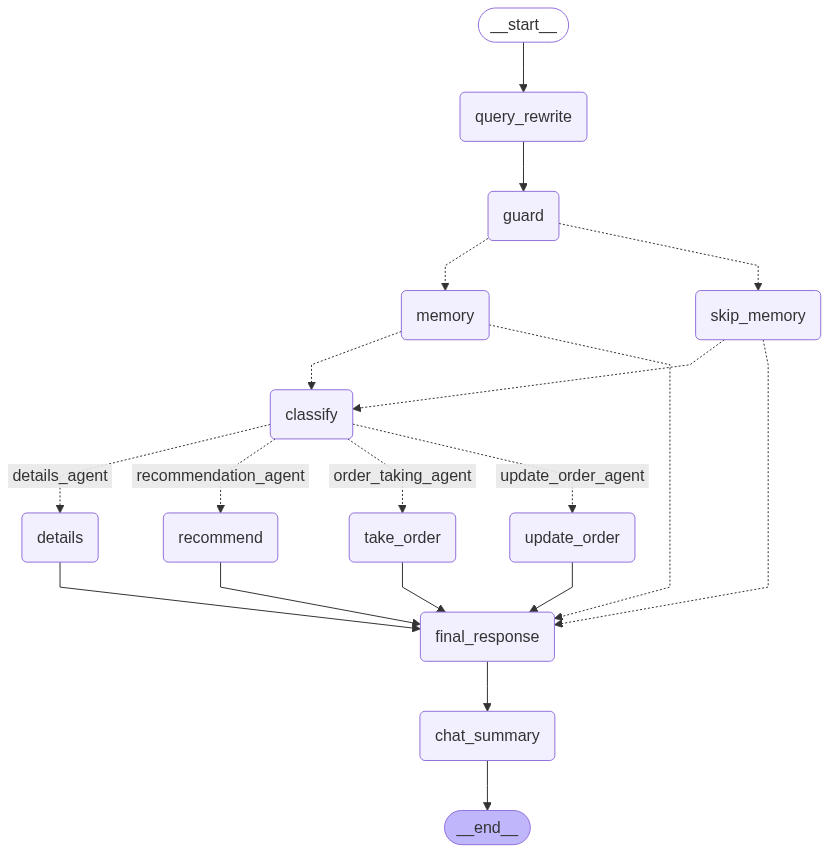

In [6]:
from IPython.display import Image , display
display(Image(build.get_graph(xray=True).draw_mermaid_png()))

In [ ]:
config = 

In [11]:
# 📁 File: Backend/main.py
# from Backend.graph.order_graph import order_agent

if __name__ == "__main__":
    print("\n☕ Welcome to the Coffee Shop Bot! Ask anything or type 'exit' to quit.\n")
    while True:
        user_input = input("You: ")
        if user_input.lower() in ["exit", "quit"]:
            break
        state = order_agent.invoke({"user_input": user_input})
        print("\nDone. Waiting for your next command...\n")


☕ Welcome to the Coffee Shop Bot! Ask anything or type 'exit' to quit.



/var/folders/42/94lj0cp519ncj7_m79j3_h3m0000gn/T/ipykernel_54669/914286412.py:10: PydanticDeprecatedSince20: The `copy` method is deprecated; use `model_copy` instead. See the docstring of `BaseModel.copy` for details about how to handle `include` and `exclude`. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.11/migration/
  return state.copy(update={"parsed_items": parsed})
/var/folders/42/94lj0cp519ncj7_m79j3_h3m0000gn/T/ipykernel_54669/914286412.py:15: PydanticDeprecatedSince20: The `copy` method is deprecated; use `model_copy` instead. See the docstring of `BaseModel.copy` for details about how to handle `include` and `exclude`. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.11/migration/
  return state.copy(update={"available_items": output})
/var/folders/42/94lj0cp519ncj7_m79j3_h3m0000gn/T/ipykernel_54669/914286412.py:26: PydanticDeprecatedSince

✅ Latte x2 — ₹120.0 each

🧾 Total: ₹240.0

Would you like to confirm this order or make changes?

Done. Waiting for your next command...



/var/folders/42/94lj0cp519ncj7_m79j3_h3m0000gn/T/ipykernel_54669/914286412.py:10: PydanticDeprecatedSince20: The `copy` method is deprecated; use `model_copy` instead. See the docstring of `BaseModel.copy` for details about how to handle `include` and `exclude`. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.11/migration/
  return state.copy(update={"parsed_items": parsed})
/var/folders/42/94lj0cp519ncj7_m79j3_h3m0000gn/T/ipykernel_54669/914286412.py:15: PydanticDeprecatedSince20: The `copy` method is deprecated; use `model_copy` instead. See the docstring of `BaseModel.copy` for details about how to handle `include` and `exclude`. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.11/migration/
  return state.copy(update={"available_items": output})
/var/folders/42/94lj0cp519ncj7_m79j3_h3m0000gn/T/ipykernel_54669/914286412.py:26: PydanticDeprecatedSince

✅ Latte x2 — ₹120.0 each

🧾 Total: ₹240.0

Would you like to confirm this order or make changes?
✅ Latte x2 — ₹120.0 each

🧾 Total: ₹240.0

Would you like to confirm this order or make changes?
✅ Latte x2 — ₹120.0 each

🧾 Total: ₹240.0

Would you like to confirm this order or make changes?

Done. Waiting for your next command...



In [ ]:
from langchain_groq import ChatGroq
from langchain.output_parsers import PydanticOutputParser
from langchain.prompts import PromptTemplate
from langchain.schema import HumanMessage

llm = ChatGroq(model=os.getenv("GROQ_MODEL_NAME"), temperature=0)

parser = PydanticOutputParser(pydantic_object=List[ProductItem])

prompt_template = PromptTemplate.from_template(
    "Extract all order items and their quantities from this message:\n\n{user_input}\n\n{format_instructions}"
)

In [13]:
def parse_input(state: OrderAgentState) -> OrderAgentState:
    prompt = prompt_template.format_prompt(
        user_input=state.user_input,
        format_instructions=parser.get_format_instructions()
    )
    response = llm([HumanMessage(content=prompt.to_string())])
    parsed_items = parser.parse(response.content)

    return state.copy(update={"parsed_items": parsed_items})